In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms import community as cm

### Introdução 

Uma das tarefas que é comum em análise de redes complexas é agrupar os vértices da rede em subconjuntos, chamados de comunidades, de modo que os vértices mais similares fiquem juntos em uma comunidade. 

A ideia central é entender um pouco sobre como os nós tendem a se organizar dentro da rede através da observação dos padrões de ligação que os mesmos possuem.

Problemas de detecção de comunidades são similares a problemas de partição em grafos, mas em geral nestes últimos já há uma quantidade pré-determinada de grupos e dos tamanhos dos mesmos no qual o grafo deve ser particionado, o que não ocorre em geral com os problemas de detecção de comunidades nos quais o tamanho e a quantidade de comunidades a serem detectadas não são previamente conhecidos

- **nx.karate_club_graph()** 

Returns Zachary's Karate Club graph.

Each node in the returned graph has a node attribute 'club' that indicates the name of the club to which the member represented by that node belongs, either 'Mr. Hi' or 'Officer'. 

Each edge has a weight based on the number of contexts in which that edge's incident node members interacted.

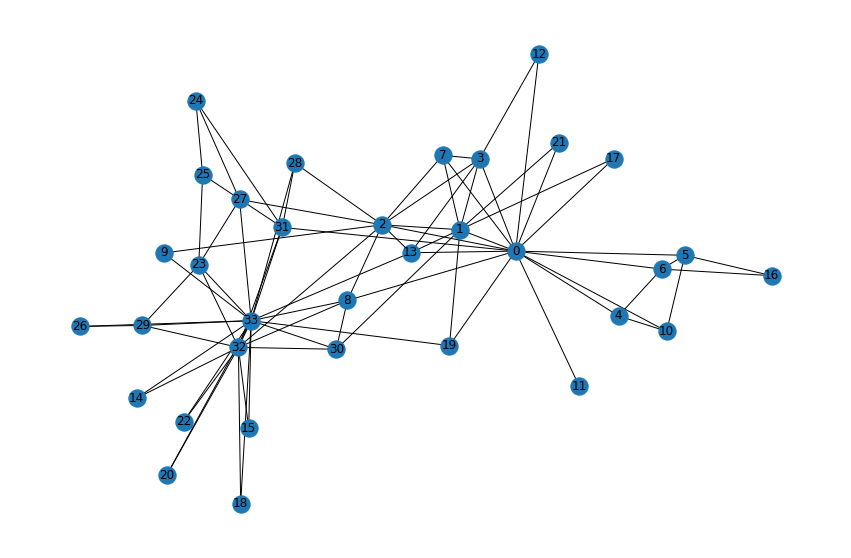

In [221]:
# Exemplo

G = nx.karate_club_graph()

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(G,with_labels=True)

### CONCOR

É um dos primeiros e mais usados métodos para detectar comunidades. 

Ele é baseado na convergência de correlações iteradas.

O método CONCOR aplicado uma única vez, divide o conjunto de nós em no máximo duas comunidades. 
Se mais comunidades forem necessárias, pode-se aplicar novamente o método CONCOR em uma comunidade encontrada anteriormente, dividindo-a em duas.

**Exemplo**

Considerar novamente o exemplo do livro 2 da saga Harry Potter. 

Recorde que as ligações na rede representam suporte emocional e, portanto, trata-se de uma rede direcionada com matriz de adjacência não simétrica.

Usamos o algoritmo **CONCOR** para achar uma divisão em duas comunidades. 

Excluímos os nós isolados. 
Estes vértices podem ser considerados uma comunidade separada, mas alguns deles correspondem a personagens que não fazem parte do livro. 

A convergência do algoritmo é detectada usando a função **all_close** de Numpy porque, trabalhando com aritmética de ponto flutante, existe a possibilidade de que os elementos da matriz $C_k$ não fiquem exatamente iguais a $+-1$. 

As correlações são feitas usando a função **corr_coef** de Numpy. 

A função **adjacency_matrix** devolve a matriz em um formato especial para matrizes esparsas. 

Antes de começar o algoritmo CONCOR, primeiro convertemos a matriz a um formato denso com **todense**.

**Exemplo**

Utilize os algoritmos no exemplo dos personagens do segundo livro da saga de Harry Potter.

In [6]:
atri = pd.read_csv('../data/harrypotter/hpattributes.txt', sep='\t')
ares = pd.read_csv('../data/harrypotter/hpbook2.txt', sep=' ', header=None)
nome = pd.read_csv('../data/harrypotter/hpnames.txt', sep='\t')

In [7]:
# criando a rede

gpotter = nx.DiGraph()

n = atri.shape[0]

for k in range(n):
    gpotter.add_node(k,
                     nome = nome['name'][k],
                     ano = atri['schoolyear'][k],
                     gen = atri['gender'][k],
                     casa = atri['house'][k])

for k in range(n):
    for m in range(n):
        if ares.values[k][m] == 1:
            gpotter.add_edge(k,m)

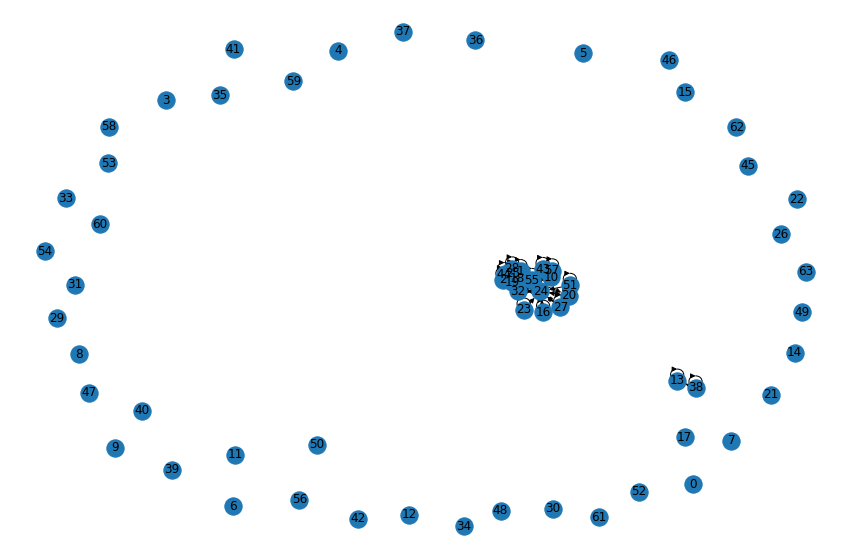

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(gpotter,with_labels=True)

In [9]:
# Matriz de adjacência esparsa
A = nx . adjacency_matrix ( gpotter )

# Apagamos os nós isolados :
isolados = []
for k in range(n):
    if np.sum(A[[k],:]) == 0:
        isolados.append(k)
        gpotter.remove_node(k)

print(len(isolados), 'nos isolados')

44 nos isolados


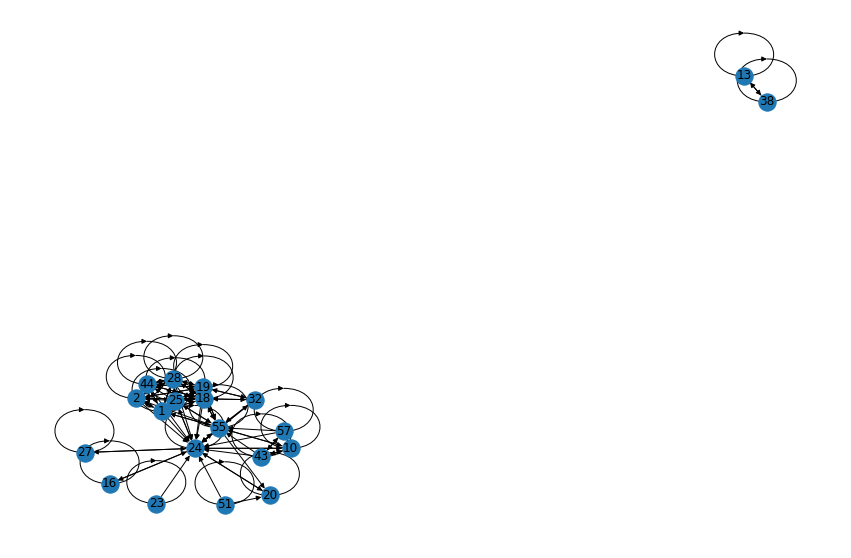

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(gpotter,with_labels=True)

In [11]:
# matriz de adjacencia esparsa
A = nx.adjacency_matrix(gpotter)

# matriz de adjacencia densa
A = np.array(A.todense(),dtype=float)

In [12]:
# algoritmo CONCOR
C = A.copy()

while not np.allclose(np.abs(C), np.ones_like(C), atol=1e-10):
    C = np.corrcoef(C)

C = np.round(C)

**allclose()**

Returns True if two arrays are element-wise equal within a tolerance.

**ones_like()**

Return an array of ones with the same shape and type as a given array.

 **corrcoef()**

Return Pearson product-moment correlation coefficients.

In [237]:
# algoritmo CONCOR

com1 = []
com2 = []

nos  = list(gpotter.nodes)

com1.append(nos[0])

for k in range(1,len(nos)):
    if C[0,k] > 0:
        com1.append(nos[k])
    else:
        com2.append(nos[k])

In [238]:
print('Comunidade 1:')
for k in range(len(com1)):
    print(gpotter.nodes[com1[k]]['nome'])

Comunidade 1:
Alicia Spinnet
Angelina Johnson
Fred Weasley
George Weasley
Hermione Granger
Katie Bell
Lee Jordan
Oliver Wood
Ronald Weasley


In [239]:
print('Comunidade 2:')
for k in range(len(com2)):
    print(gpotter.nodes[com2[k]]['nome'])

Comunidade 2:
Dean Thomas
Draco Malfoy
Ernie Macmillan
Ginny Weasley
Hannah Abbott
Harry James Potter
Justin Finch-Fletchley
Marcus Flint
Neville Longbottom
Percy Weasley
Seamus Finnigan


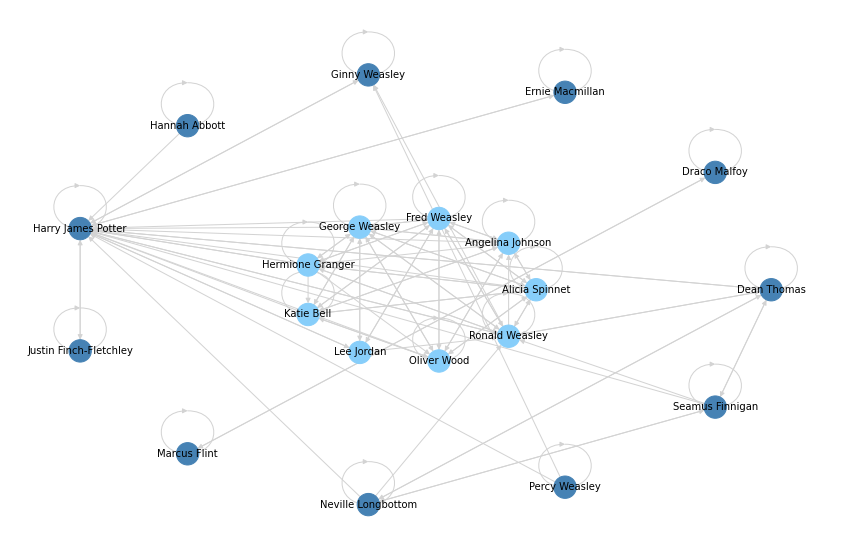

In [240]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 100*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 100*np.sin(2*np.pi*k/len(com1))

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')
    
etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)

plt.box(False)
plt.show()

Os problemas de divisão de um grafo em comunidades são, comumente, muito complexos. 

Daí que existam algoritmos heurísticos ou baseados em algoritmos guloso. 

Os scripts python a seguir minimiza a razão entre o número de arestas que ligam dois grupos e o produto dos tamanhos dos dois grupos, 
aplicado a uma rede de personagens do livro 2 da saga Harry Potter.

O sub-pacote **algorithms.community** do Networkx contém várias funções relacionadas a busca de comunidades em redes.

O primeiro número que devolve a função **partition_quality** é a razão entre o número de arestas internas aos grupos e o número total de arestas. 

In [244]:
mper = +np.inf
for ini in gpotter.nodes:
    com1 = set([ini])
    com2 = set(nos) - com1
    
    mgan = -1
    while mgan < 0:
        cv, pe = cm.partition_quality(gpotter,[com1,com2])
        ra = (1-cv)/(len(com1)*len(com2)) 
        mgan = +np.inf
        mno  = -1
        for no in com2:
            ncom1 = com1.union(set([no]))
            ncom2 = com2 - set([no])
            cv,pe = cm.partition_quality(gpotter,[ncom1,ncom2])
            nra   = (1-cv)/(len(ncom1)*len(ncom2))
            ng    = nra-ra
            if ng < mgan:
                mgan = ng
                mno  = no
        if mgan < 0:
            com1.add(mno)
            com2.remove(mno)
    
    cv,pe = cm.partition_quality(gpotter,[com1,com2])            
    ra = (1-cv)/(len(com1)*len(com2)) 

    if ra < mper:
        mper = ra
        mcom1 = com1.copy()
        mcom2 = com2.copy()

In [245]:
com1 = list(mcom1)
com2 = list(mcom2)

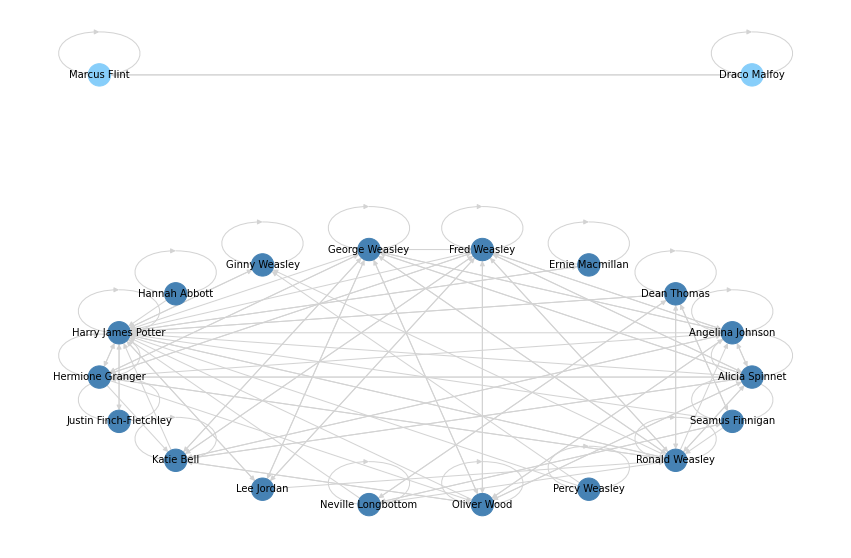

In [248]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500, 
                 labels=etiquetas,
                 font_size=10, 
                 node_color=cores)

plt.box(False)
plt.show()

Um algoritmo de bisseção muito conhecido é o algoritmo de **Kernighan e Lin**. 

Este algoritmo guloso começa com uma partição do grafo (dada ou ao acaso) e prossegue trocando dois nós, um de cada grupo, de maneira de aprimorar a partição.

A seguir aplicamos o algoritmo **Kernighan e Lin** a uma rede de personagens do livro 2 da saga Harry Potter.

**cm.kernighan_lin_bisection()**

Partition a graph into two blocks using the **Kernighan–Lin** algorithm.

This algorithm partitions a network into two sets by iteratively swapping pairs of nodes to reduce the edge cut between the two sets. 

The pairs are chosen according to a modified form of **Kernighan-Lin**, which moves node individually, alternating between sides to keep the bisection balanced.

In [13]:
# Algoritmo Kernighan e Lin aplicado a uma rede de personagens do segundo livro da saga Harry Potter.
com1, com2 = cm.kernighan_lin_bisection(gpotter.to_undirected(), max_iter=100)

In [17]:
print("com1:",com1)
print("com2:",com2)

com1: [32, 10, 43, 51, 20, 23, 55, 24, 57, 27]
com2: [1, 2, 38, 44, 13, 16, 18, 19, 25, 28]


In [18]:
com1 = list(com1)
com2 = list(com2)

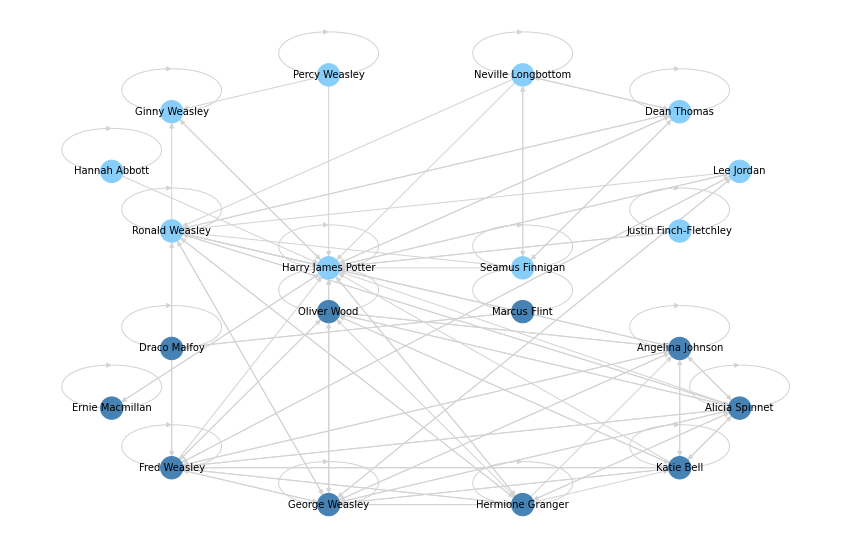

In [19]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

#plt.figure()
nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()